# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [108]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 100

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10))

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear_relu_stack(x)
        return x

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = Net()

model = model.to(device)
model.train()

Net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, label, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    model.eval()
    # x.requires_grad_()
    output = model(x)
    loss = F.cross_entropy(output, label)

    grad = torch.autograd.grad(
                loss, x, retain_graph=False, create_graph=False
            )[0]

    x_adv = x.detach() + eps * torch.sign(grad)
    return x_adv



def pgd_untargeted(model, x, y, k, eps, eps_step):
    #TODO: implement this 
    # Notes: put the model in eval() mode for this function
    
    model.eval()
    adv_images = x.clone().detach()
    for _ in range(k):
        adv_images.requires_grad = True
        x_adv = fgsm(model, adv_images, y, eps_step)
        delta = torch.clamp(x_adv - x, min=-eps, max=eps)
        adv_images = torch.clamp(x + delta, min = 0, max = 1)
    
    return adv_images


In [12]:
def train_model(model, train_loader, num_epochs, enable_defense=True, attack='pgd', eps=0.1):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)
    model.train()

    lr = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(num_epochs):
        for index, (images, labels) in enumerate(train_loader):
            logits = model(images)
            optimizer.zero_grad()

            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item():.3f}')

    # if enable_defense:
    #         for epoch in range(num_epochs):
    #             for index, (images, labels) in enumerate(train_loader):
    #                 adversary_images = pgd_untargeted(model, images, labels, 10,  eps, 0.01)
    #                 model.train()
    #                 optimizer.zero_grad()
    #                 logits = model(adversary_images)
    #                 loss = F.cross_entropy(logits, labels)
    #                 loss.backward()
    #                 optimizer.step()
                    
    #             print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item():.3f}')

## Standard Training

In [13]:
## train the original model
model = model.to(device)
model.train()

train_model(model, train_loader, 30, False)
torch.save(model.state_dict(), 'standard-weights.pt')

Epoch [0/30] Loss = 0.136
Epoch [1/30] Loss = 0.074
Epoch [2/30] Loss = 0.026
Epoch [3/30] Loss = 0.106
Epoch [4/30] Loss = 0.047
Epoch [5/30] Loss = 0.035
Epoch [6/30] Loss = 0.060
Epoch [7/30] Loss = 0.212
Epoch [8/30] Loss = 0.122
Epoch [9/30] Loss = 0.128
Epoch [10/30] Loss = 0.010
Epoch [11/30] Loss = 0.002
Epoch [12/30] Loss = 0.014
Epoch [13/30] Loss = 0.008
Epoch [14/30] Loss = 0.013
Epoch [15/30] Loss = 0.001
Epoch [16/30] Loss = 0.017
Epoch [17/30] Loss = 0.004
Epoch [18/30] Loss = 0.001
Epoch [19/30] Loss = 0.001
Epoch [20/30] Loss = 0.004
Epoch [21/30] Loss = 0.056
Epoch [22/30] Loss = 0.000
Epoch [23/30] Loss = 0.007
Epoch [24/30] Loss = 0.025
Epoch [25/30] Loss = 0.001
Epoch [26/30] Loss = 0.014
Epoch [27/30] Loss = 0.000
Epoch [28/30] Loss = 0.005
Epoch [29/30] Loss = 0.000


### Standard Accuracy

In [14]:
correct = 0
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  logits = model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 10000))

Accuracy = 97.37%


In [44]:
def interval_analysis(model: Net, inputs, epsilon):
    inputs = inputs.view(inputs.size(0), -1)
    lb = inputs - epsilon
    ub = inputs + epsilon

    layers = model.linear_relu_stack
    for index in range(0,len(layers) - 1, 2):
        layer = layers[index]
        weight, bias = layer.weight, layer.bias

        curr_lb = torch.matmul(lb, weight.t()) + bias
        curr_ub = torch.matmul(ub, weight.t()) + bias
        
        curr_lb = torch.relu(curr_lb)
        curr_ub = torch.relu(curr_ub)

        lb = torch.minimum(curr_lb, curr_ub)
        ub = torch.maximum(curr_lb, curr_ub)

    layer = layers[-1]
    weight, bias = layer.weight, layer.bias

    curr_lb = torch.matmul(lb, weight.t()) + bias
    curr_ub = torch.matmul(ub, weight.t()) + bias

    lb = torch.minimum(curr_lb, curr_ub)
    ub = torch.maximum(curr_lb, curr_ub)

    return lb, ub

def evaluate_robustness(model, test_loader, epsilons):
    model.eval()
    robust_accuracies  = []
    with torch.no_grad():
        for epsilon in epsilons:
            correct = 0
            total = 0
            for j, (images, labels) in enumerate(test_loader):
                lb, ub = interval_analysis(model, images, epsilon)
                lb_values = lb[torch.arange(images.size(0)), labels]

                mask = torch.full_like(ub, float('-inf'))
                mask[torch.arange(images.size(0)), labels] = ub[torch.arange(images.size(0)), labels]
                outputs_masked = torch.where(mask == ub, float('-inf'), ub)
                max_values_excluding_class = outputs_masked.max(dim=1).values
                
                differences = lb_values > max_values_excluding_class
                correct += differences.sum().item()
                total += labels.size(0)
            accuracy = correct / total
            robust_accuracies.append(accuracy)
            print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.4f}")
        return robust_accuracies
            # _, preds = torch.max(logits, 1)
            # correct += (preds == labels).sum().item()
epsilons = np.linspace(0.01, 0.1, 10)
robust_accuracies = evaluate_robustness(model, test_loader, epsilons)

Epsilon: 0.01, Accuracy: 0.0816
Epsilon: 0.020000000000000004, Accuracy: 0.0794
Epsilon: 0.030000000000000006, Accuracy: 0.0769
Epsilon: 0.04000000000000001, Accuracy: 0.0752
Epsilon: 0.05000000000000001, Accuracy: 0.0738
Epsilon: 0.06000000000000001, Accuracy: 0.0720
Epsilon: 0.07, Accuracy: 0.0708
Epsilon: 0.08, Accuracy: 0.0686
Epsilon: 0.09000000000000001, Accuracy: 0.0666
Epsilon: 0.1, Accuracy: 0.0656


Text(0.5, 1.0, 'Robust Accuracy vs Epsilon')

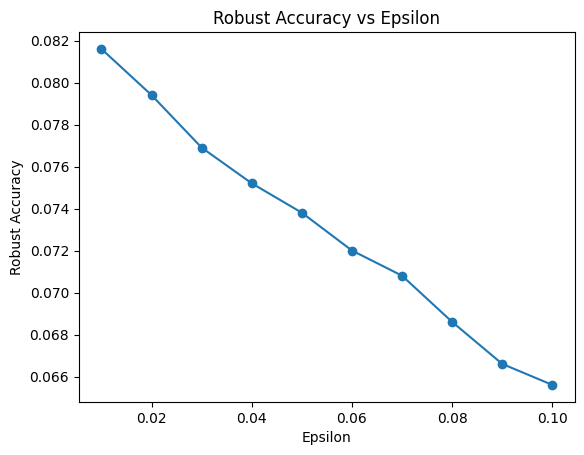

In [50]:
plt.plot(epsilons, robust_accuracies, '-o')
plt.xlabel("Epsilon")
plt.ylabel('Robust Accuracy')
plt.title("Robust Accuracy vs Epsilon")

## IBP implementation

![image](./hyper_params.png)

### Citation
Parts of code is adapted from [Github](https://github.com/pawelmorawiecki/Interval_bound_propagation) however altered for different number of epochs, bounds and personal understanding

In [123]:
#schedulers

def epsilon_scheduler(epsilon):

    epsilon_schedule = []
    step = epsilon / 10000

    for i in range(10000):
        epsilon_schedule.append(i * step)
    
    for i in range(40001):
        epsilon_schedule.append(epsilon)
    
    return epsilon_schedule

def kappa_scheduler():

    schedule = 2001 * [1]
    kappa_value = 1.0
    step = 0.5/48000

    for i in range(48000):
        kappa_value -= step
        schedule.append(kappa_value)
    return schedule

In [52]:
def bound_propagation(model: Net, init_bounds):
    l, u = init_bounds
    bounds = [init_bounds]
    for layer in model.linear_relu_stack:
        if isinstance(layer, nn.Linear):
            pos_weights = layer.weight.clamp(min = 0)
            neg_weights = layer.weight.clamp(max = 0)
            new_l = (pos_weights @ l.T + neg_weights @ u.T + layer.bias[:, None]).T # pos weights * l + neg_weights * u minimizes lower bound
            new_u = (pos_weights @ u.T + neg_weights @ l.T + layer.bias[:, None]).T # opposite case

        if isinstance(layer, nn.ReLU):
            new_l = l.clamp(min = 0)
            new_u = u.clamp(min = 0)

            unstable = (l < 0) & (u > 0)
            new_l[unstable] = 0

        l = new_l
        u = new_u
        bounds.append([new_l, new_u])
    return bounds


In [53]:
def get_final_bound(model: Net, C, bounds, idx):
    last_W = C.T @ model.linear_relu_stack[-1].weight
    last_b = C.T @ model.linear_relu_stack[-1].bias

    l, u = bounds[-2]
    #just return lower bound since we care about worst case
    return (last_W.clamp(min=0) @ l[idx].T + last_W.clamp(max=0) @ u[idx].T + last_b[:,None]).T

In [100]:
def robust_train_loop(train_loader, model, epsilon_scheduler, kappa_scheduler, batch_counter, optimizer):
    model.train()
    robust_err = 0
    # total_robust_loss = 0
    total_combined_loss = 0

    # Matrix that when multiplied logits by will give max/min o
    C = [-torch.eye(10) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X, y in train_loader:
        # Fit loss 
        y_prediction = model(X)
        fit_loss = nn.CrossEntropyLoss()(y_prediction, y)

        # Spec Loss
        X = X.view(X.size(0), -1)
        initial_bound = (X + epsilon_scheduler[batch_counter], X - epsilon_scheduler[batch_counter])
        bounds = bound_propagation(model, initial_bound)
        robust_loss = 0
        for idx in range(10):
            if sum(y==idx) > 0:
                lower_bound = get_final_bound(model, C[idx], bounds, y==idx)
                """
                Explanation of below lines:
                For each index, we take only the samples from that batch that have a class == index
                Then we compare the lower bounds to the expected class. realistically the lower bound list contains the distance from the class each logit is.
                positive value means likelinesss of logit_i==y > logit_i!=y
                Then when we take the crossentropy, we negate the lower bound since if the prediction is good, all the other values are negative indicating a small probabilty
                """
                robust_loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==idx]) / X.shape[0]

                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        # total_robust_loss += robust_loss.item() * X.shape[0]

        #combined loss
        combined_loss = (kappa_scheduler[batch_counter])*(fit_loss) + (1-kappa_scheduler[batch_counter])*(robust_loss)
        total_combined_loss += combined_loss.item()

        batch_counter += 1
    
        if optimizer:
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

    return robust_err / len(train_loader), total_combined_loss/len(train_loader)




In [115]:
def test_model(model, test_loader):
    correct = 0
    model.eval()
    for j, (images, labels) in enumerate(test_loader):
        images, labels = images, labels
        logits = model(images)
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
    return correct/len(test_loader.dataset)

def test_robust_model(model, test_loader, epsilon):
    C = [-torch.eye(10) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1


    robust_err = 0.0
    model.eval()
    for j, (images, labels) in enumerate(test_loader):
        images = images.view(images.size(0), -1)
        init_bounds = (images - epsilon, images + epsilon)
        bounds = bound_propagation(model, init_bounds)
        for idx in range(10):
            if sum(labels==idx) > 0:
                lower_bound = get_final_bound(model, C[idx], bounds, labels==idx)
                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item()

    return robust_err/len(test_loader.dataset)

In [122]:
model = Net()

model = model.to(device)
model.train()
torch.manual_seed(42)
opt = optim.Adam(model.parameters(), lr=1e-3)

EPSILON = 0.1
epsilon_schedule = epsilon_scheduler(EPSILON)
kappa_schedule = kappa_scheduler()
batch_counter = 0

print("Epoch   ", "Combined Loss", "Test Acc", "Test Robust Err", sep="\t")
losses = []
test_errs = []
robust_errs = []
training_robust_errs = []
for t in range(100):
    training_robust_err, combined_loss = robust_train_loop(train_loader, model, epsilon_schedule, kappa_schedule, batch_counter, opt)
    batch_counter += 500
    
    if t == 24:  #decrease learning rate after 25 epochs
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-4

    if t == 49:  #decrease learning rate after 49 epochs
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-5
    
    test_err = test_model(model, test_loader)
    robust_err = test_robust_model(model, test_loader, EPSILON)
    test_errs.append(test_err)
    robust_errs.append(robust_err)

    print(*("{:.6f}".format(i) for i in (t, combined_loss, test_err, robust_err)), sep="\t")

    training_robust_errs.append(training_robust_err)
    losses.append(combined_loss)


Epoch   	Combined Loss	Test Err	Test Robust Err
0.000000	0.498740	0.925300	1.000000
10.000000	0.046384	0.971300	1.000000
20.000000	0.014920	0.973400	1.000000


KeyboardInterrupt: 

In [105]:
x = torch.tensor([[ 0.0000, 18.2334,  8.1572, 15.0878, 25.3393,  7.7511,  9.6636, 17.2925,
         10.7932, 17.1215],
        [ 0.0000, 14.8671,  8.8950,  9.6338, 12.9776,  5.2151, 10.9705, 11.0506,
          9.6674, 10.8431],
        [ 0.0000, 11.5153,  4.5781,  8.3999, 15.9921,  5.0835,  7.3418,  8.6893,
          4.8071,  8.7620],
        [ 0.0000, 10.8952,  6.7174,  5.9629,  8.9658,  2.3005,  5.7246,  7.8472,
          7.2822, 10.0743],
        [ 0.0000, 13.9882,  8.8359, 11.0458, 13.4222,  5.2202,  8.3964, 10.7163,
          9.5742, 10.3002],
        [ 0.0000, 10.5153,  6.3486,  7.9926,  8.2773,  3.3717,  2.4933,  9.2928,
          6.4199,  8.4228],
        [ 0.0000, 17.6194,  8.3043, 13.4829, 21.4512,  8.5918, 10.0416, 14.0710,
          9.0490, 13.5330],
        [ 0.0000,  5.0181,  1.8789,  2.4534,  6.0787,  1.2094,  4.4104,  4.1585,
          1.5410,  2.3737],
        [ 0.0000, 21.9924, 11.0901, 14.4630, 24.9786,  9.6433, 15.4083, 16.3441,
         10.9652, 14.3005],
        [ 0.0000, 13.2877,  4.8341,  7.3551, 16.4596,  5.1211, 11.5874,  6.0103,
          5.2093,  5.6235],
        [ 0.0000, 10.8487,  4.3757,  7.9740, 13.4431,  5.1206,  6.5710,  6.6536,
          5.0721,  7.3472],
        [ 0.0000, 14.5576,  7.9286, 10.2530, 17.8881,  4.7228, 10.1843, 11.7837,
          8.4454, 10.6933],
        [ 0.0000, 15.1551,  7.8471, 12.2526, 22.3608,  5.0295, 12.0667, 12.3506,
          8.4002, 11.3248]])
s = torch.tensor(13*[0])

print(nn.CrossEntropyLoss(reduction='sum')(-x, s))
print(x.min(dim=1))

tensor(0.9586)
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False])


In [120]:
print(batch_counter)

24500


In [114]:
len(test_loader.dataset)

10000